In [1]:
from pathlib import Path

import earthkit.plots
import eccodes
import numpy as np

In [2]:
data = Path("data") / "cems-ercnfdr" / "data.grib"

In [3]:
with data.open("rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)
    grib_keys = []
    it = eccodes.codes_keys_iterator_new(gid)
    while eccodes.codes_keys_iterator_next(it):
        grib_keys.append(eccodes.codes_keys_iterator_get_name(it))
    eccodes.codes_keys_iterator_delete(it)
    eccodes.codes_release(gid)

In [4]:
with data.open("rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)
    (long_name,) = eccodes.codes_get_array(gid, "name", ktype=str)
    (year,) = eccodes.codes_get_array(gid, "year")
    (month,) = eccodes.codes_get_array(gid, "month")
    (day,) = eccodes.codes_get_array(gid, "day")
    (hour,) = eccodes.codes_get_array(gid, "hour")
    (minute,) = eccodes.codes_get_array(gid, "minute")
    (missing_value,) = eccodes.codes_get_array(gid, "missingValue")
    latitudes = eccodes.codes_get_array(gid, "latitudes")
    longitudes = eccodes.codes_get_array(gid, "longitudes")
    ercnfdr = eccodes.codes_get_array(gid, "values")
    eccodes.codes_release(gid)

In [5]:
missing_value

np.int64(9999)

In [6]:
def plot(ercnfdr: np.ndarray, title_prefix: str):
    chart = earthkit.plots.Map()

    chart.pcolormesh(
        z=np.where(ercnfdr == missing_value, np.nan, ercnfdr), x=longitudes, y=latitudes
    )

    chart.coastlines()
    chart.borders()
    chart.gridlines()

    chart.legend(label=long_name)

    chart.title(
        f"{title_prefix}{long_name} on {day:02}.{month:02}.{year} at {hour:02}:{minute:02}"
    )

    chart.show()

/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/components/subplots.py:562: UserWarning: pcolormesh failed with raw data, attempting interpolation to structured grid with default interpolation options.
  warnings.warn(


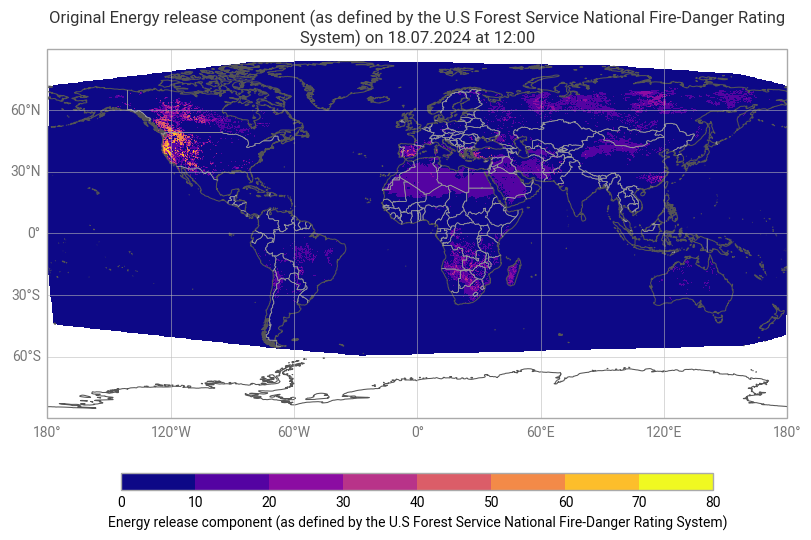

In [7]:
plot(ercnfdr, "Original ")

In [8]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [9]:
sperr = Sperr(mode="pwe", pwe=1)
ercnfdr_sperr = sperr.decode(sperr.encode(ercnfdr))

In [10]:
sz3 = Sz3(eb_mode="abs", eb_abs=1)
ercnfdr_sz3 = sz3.decode(sz3.encode(ercnfdr))

In [11]:
zfp = Zfp(mode="fixed-accuracy", tolerance=1)
ercnfdr_zfp = zfp.decode(zfp.encode(ercnfdr))

/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/components/subplots.py:562: UserWarning: pcolormesh failed with raw data, attempting interpolation to structured grid with default interpolation options.
  warnings.warn(


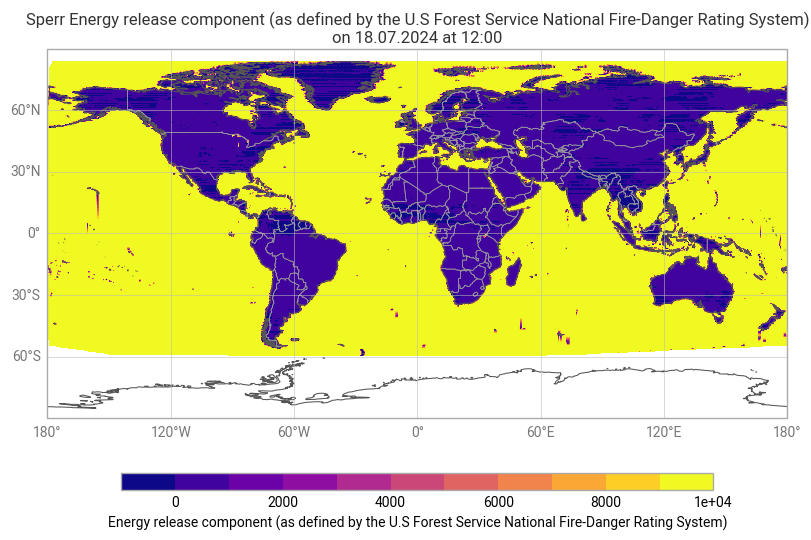

In [12]:
plot(ercnfdr_sperr, "Sperr ")

/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/components/subplots.py:562: UserWarning: pcolormesh failed with raw data, attempting interpolation to structured grid with default interpolation options.
  warnings.warn(


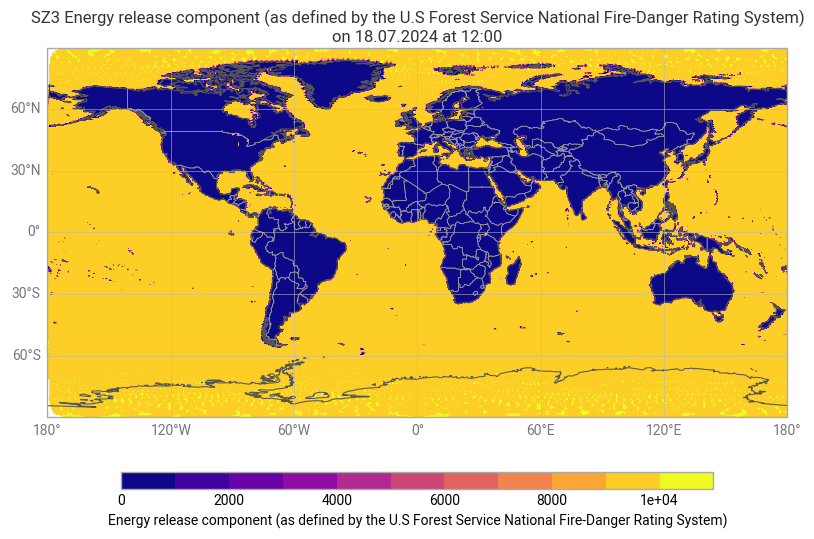

In [13]:
plot(ercnfdr_sz3, "SZ3 ")

/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/components/subplots.py:562: UserWarning: pcolormesh failed with raw data, attempting interpolation to structured grid with default interpolation options.
  warnings.warn(


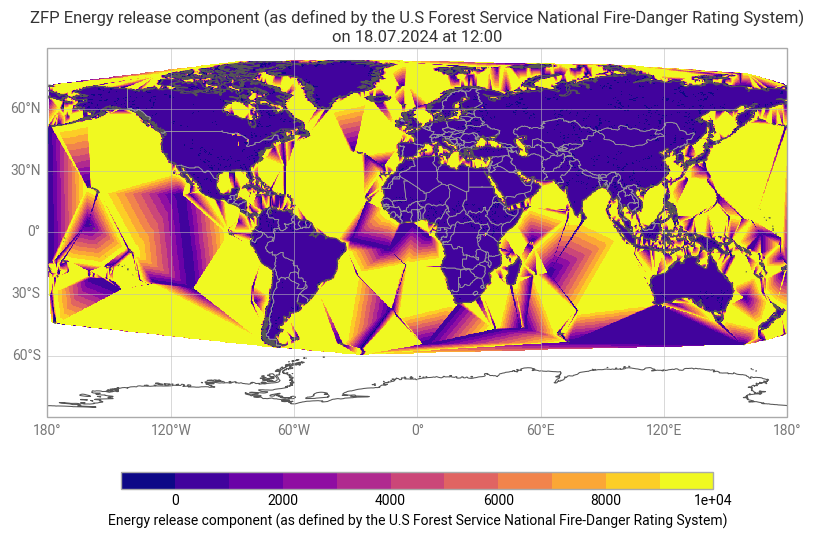

In [14]:
plot(ercnfdr_zfp, "ZFP ")

In [15]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [16]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=1),
        dict(kind="same", value=missing_value, exclusive=True),
    ],
)
ercnfdr_sg = sg.decode(sg.encode(ercnfdr))

/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/components/subplots.py:562: UserWarning: pcolormesh failed with raw data, attempting interpolation to structured grid with default interpolation options.
  warnings.warn(


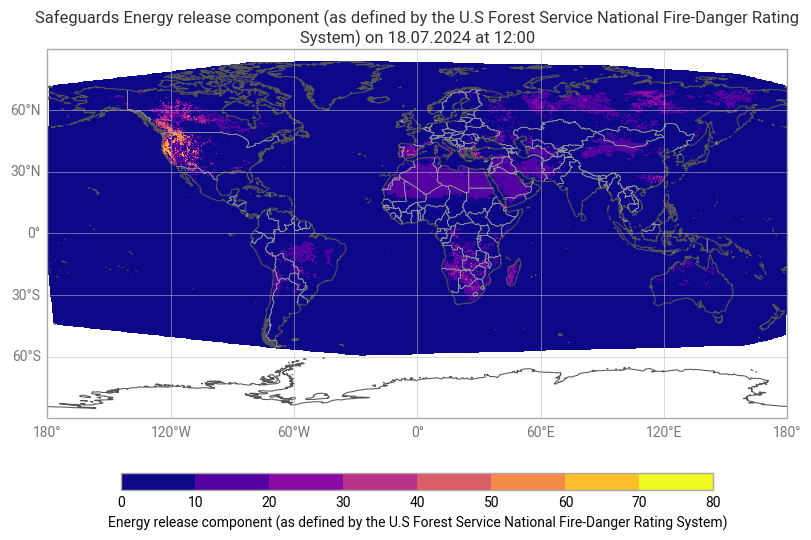

In [17]:
plot(ercnfdr_sg, "Safeguards ")